In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics # метрики
from sklearn import model_selection # методы разделения и валидации
from sklearn import ensemble # ансамбли

plt.style.use('seaborn')
%matplotlib inline

In [34]:
shoppers_data = pd.read_csv('data/online_shoppers_intention.csv')
shoppers_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [35]:
display(shoppers_data.shape)

(12330, 18)

In [36]:
display(shoppers_data.isna().sum())

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [37]:
# закодируем категориальные признаки
dummy_data = pd.get_dummies(shoppers_data)
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


Non-fraud transactions: 84.53%
Fraud transactions: 15.47%


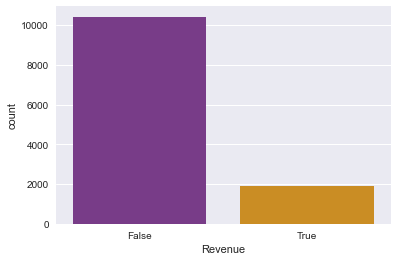

In [38]:
# Визуализация целевого признака
sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
clas_percent = dummy_data['Revenue'].value_counts(normalize=True) * 100
print('Non-fraud transactions: {:.2f}%'.format(clas_percent[0]))
print('Fraud transactions: {:.2f}%'.format(clas_percent[1]))

In [39]:
X, y = dummy_data.drop('Revenue', axis=1), dummy_data['Revenue']

In [40]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train shape: (9864, 28)
Test shape: (2466, 28)


In [41]:
# Создаем объект класса случайный лес
rf_clf = ensemble.RandomForestClassifier(
    random_state=42
)

# Создаем объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

# Считаем метрики на кросс-валидации
cv_metrics = model_selection.cross_validate(
    estimator=rf_clf,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='f1',
    return_train_score=True
    
)

In [42]:
display('Train k-fold mean f1-score: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
display('Valid k-fold mean f1-score: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

'Train k-fold mean f1-score: 1.00'

'Valid k-fold mean f1-score: 0.65'

In [43]:
models_list = [
    ensemble.RandomForestClassifier(
    n_estimators = 200,
    max_depth = 5,
    min_samples_leaf = 5,
    random_state = 42
    ),
    ensemble.RandomForestClassifier(
    n_estimators = 200,
    max_depth = 7,
    min_samples_leaf = 5,
    random_state = 42
    ),
    ensemble.RandomForestClassifier(
    n_estimators = 200,
    max_depth = 12,
    min_samples_leaf = 5,
    random_state = 42
    ),
]

def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring="f1",  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

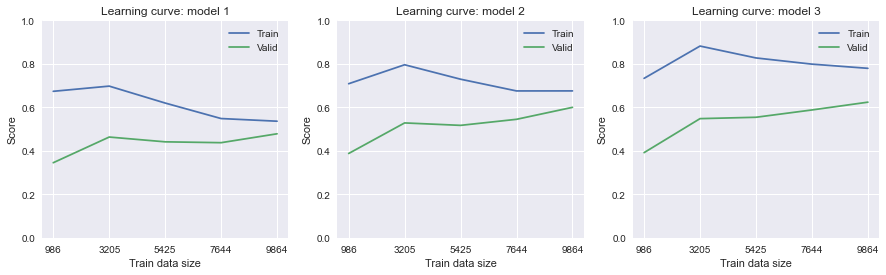

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
# Создаем цикл по списку моделей и индексам этого списка
for i, model in enumerate(models_list):
    plot_learning_curve(model, X, y, skf, ax=axes[i], title=f'model {i+1}')

In [45]:
rf_clf_7 = ensemble.RandomForestClassifier(
    n_estimators = 200,
    max_depth = 7,
    min_samples_leaf = 5,
    random_state = 42
    )

rf_clf_7.fit(X_train, y_train)

y_test_pred = rf_clf_7.predict(X_test)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.91      0.98      0.94      2084
        True       0.79      0.49      0.60       382

    accuracy                           0.90      2466
   macro avg       0.85      0.73      0.77      2466
weighted avg       0.89      0.90      0.89      2466



Best threshold = 0.36, F1-Score = 0.69


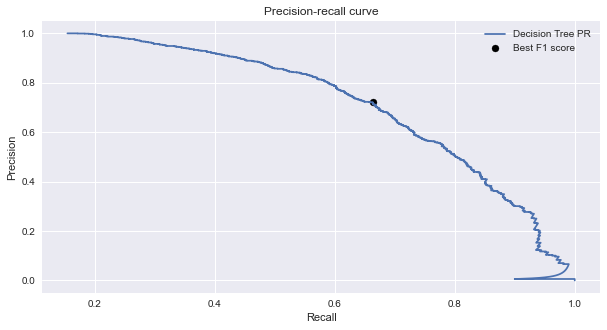

In [46]:
# Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(rf_clf_7, X_train, y_train, cv=skf, method='predict_proba')
# Выделяем столбец с вероятностями для класса 1
y_cv_proba_pred = y_cv_proba_pred[:, 1]
# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)
# Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
# Определяем индекс максимум (функция argmax())
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

# Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5))
# Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
# Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx],  marker='o', color='black', label='Best F1 score')
# Даем графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

In [51]:
thresholds_opt = 0.36
y_test_pred_proba = rf_clf_7.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba > thresholds_opt).astype('int')

# Считаем метрики
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.94      0.93      0.94      2084
        True       0.66      0.69      0.67       382

    accuracy                           0.90      2466
   macro avg       0.80      0.81      0.81      2466
weighted avg       0.90      0.90      0.90      2466

